#Import Python Libraries
Run prior to the complete notebook.

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import sklearn as skl
import plotly.express as px
import spacy
import cv2
from google.colab import files
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


#Download Dataset, NLP Model, and Test CV Library
This section takes some time to run so run it once and don't modify it too much.

In [ ]:
%pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.6.0/en_core_web_lg-3.6.0.tar.gz
nlp = spacy.load('en_core_web_lg')

# Get latest version of the smaller 200ish mb data set
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
#load data with ids and indices, each id in the table corresponds to an image as well
data = pd.read_csv(path + "/styles.csv", on_bad_lines='skip')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


#Sanity Check Test To Ensure all Dependencies are Working
This test should output the correct image, description, information, and ID for the piece of clothing picked at random.

The image and the description should match here

Index: 36739
Average color (BGR): [107.09647059 127.82411765 148.72      ]
id                                              22856
gender                                            Men
masterCategory                               Footwear
subCategory                                     Shoes
articleType                              Casual Shoes
baseColour                                      Brown
season                                         Summer
year                                           2012.0
usage                                          Casual
productDisplayName    Woodland Men Brown Casual Shoes
Name: 36739, dtype: object
Master to sub 0.735910643020703
sub to final 0.8949129672311595


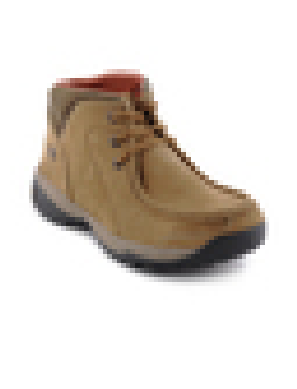

In [ ]:
#Test that a random item from the data set is correct
print("The image and the description should match here")
print("")
randomIndex = np.random.randint(data.shape[0])
print("Index:",randomIndex)
randomId = data.iloc[randomIndex]["id"]
randomImage = path + "/images/" + str(randomId) + ".jpg"
image = mpimg.imread(randomImage)
image2 = cv2.imread(randomImage)
image_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
mask = np.all(image_rgb != [255, 255, 255], axis=2)
non_white_pixels = image_rgb[mask]

average_color = np.mean(non_white_pixels, axis=0)
average_color_bgr = average_color[::-1]

print("Average color (BGR):", average_color_bgr)
print(data.iloc[randomIndex])

primaryVector = nlp(data.iloc[randomIndex]['masterCategory'])
secondaryVector = nlp(data.iloc[randomIndex]['subCategory'])
tertiaryVector = nlp(data.iloc[randomIndex]['articleType'])
print("Master to sub",primaryVector.similarity(secondaryVector))
print("sub to final",secondaryVector.similarity(tertiaryVector))
plt.imshow(image)
plt.axis('off')
plt.show()

#Data PreProcessing Code
Here we are taking only the features we need or engineering new ones from our source dataset. For example, our original dataset includes colors as strings which is not very precise. So we use CV Python libraries to extract the average color of the top after removing white space around the images. Similarly, our source dataset uses string descriptions to describe the categories underwhich a piece falls. To include this in our dataset, we use NLP Python libraries which vectorize each category to its semantic meaning, after which we calculate the difference between each category of vectors.

Disclaimer: One issue at present with our NLP approach is that even with the largest model we could use, some ethnic words like "saree" or even words which are not hyphenated are not present in the dictionary. In the future as a stretch goal we would add these words to our model or modify the data to use words which are.

This first approach to building the dataset does not use NLP to make the runtime much faster.

In [ ]:
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
import os

# Initialize results DataFrame
results = {
    'id': [],
    'gender': [],
    'red': [],
    'green': [],
    'blue': [],
    'season': [],
}

# Gender and Season Mapping
gender_map = {'Women': 0, 'Men': 1}
season_map = {'Spring': 0, 'Summer': 0, 'Fall': 1, 'Winter': 1}

# Add numeric columns to DataFrame
data['gender_numeric'] = data['gender'].map(gender_map).fillna(2).astype(int)
data['season_numeric'] = data['season'].map(season_map).fillna(2).astype(int)

# Process Images and Categories
for _, row in tqdm(data.iterrows(), total=len(data)):
    id = row['id']
    try:
        # Load image
        image_path = f"{path}/images/{id}.jpg"
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image {image_path} not found.")

        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Compute average non-white pixel colors
        mask = np.all(image_rgb != [255, 255, 255], axis=2)
        non_white_pixels = image_rgb[mask]
        if non_white_pixels.size > 0:
            average_color = np.mean(non_white_pixels, axis=0)
            red, green, blue = average_color[::-1]
        else:
            red, green, blue = 0, 0, 0
    except Exception as e:
        print(f"Error processing image {id}: {e}")
        red, green, blue = 0, 0, 0

    # Append results
    results['id'].append(id)
    results['gender'].append(row['gender_numeric'])
    results['season'].append(row['season_numeric'])
    results['red'].append(red)
    results['green'].append(green)
    results['blue'].append(blue)

# One-hot encoding
categories = ['masterCategory', 'usage', 'subCategory', 'articleType']
one_hot = pd.get_dummies(data[categories].stack()).groupby(level=0).sum()

# Combine results
processed_data = pd.DataFrame(results).join(one_hot)

# Save results
processed_data.to_csv('Export.csv', index=False)
print("Processing complete! Exported as Export.csv!")



 15%|█▌        | 6797/44424 [00:08<00:42, 878.64it/s]

Error processing image 39403: Image /root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-small/versions/1/images/39403.jpg not found.


 37%|███▋      | 16404/44424 [00:15<00:22, 1237.54it/s]

Error processing image 39410: Image /root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-small/versions/1/images/39410.jpg not found.


 73%|███████▎  | 32449/44424 [00:28<00:08, 1376.90it/s]

Error processing image 39401: Image /root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-small/versions/1/images/39401.jpg not found.


 82%|████████▏ | 36622/44424 [00:32<00:05, 1323.67it/s]

Error processing image 39425: Image /root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-small/versions/1/images/39425.jpg not found.


 90%|█████████ | 40134/44424 [00:35<00:04, 864.53it/s]

Error processing image 12347: Image /root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-small/versions/1/images/12347.jpg not found.


100%|██████████| 44424/44424 [00:39<00:00, 1127.16it/s]


Processing complete!


This approach does use NLP to vectorize the distance between categories.
#WARNING this code block will run for at minimum 20-30 minutes and will crash your computer if run locally (unless you have beefy specs)

In [ ]:
from tqdm import tqdm  # Progress bar
import pandas as pd
import numpy as np
import cv2

# Initialize results dictionary
results = {
    'id': [],
    'gender': [],
    'subCategory': [],
    'articleType': [],
    'red': [],
    'green': [],
    'blue': [],
    'season': [],
    'Topwear': [],
    'Bottomwear': [],
    'Footwear': [],
}


# One hot encoding Gender and Season Processing
gender_map = {'Women': 0, 'Men': 1}
data['gender_numeric'] = data['gender'].map(gender_map).fillna(2).astype(int)
data['season_numeric'] = data['season'].apply(
    lambda x: 0 if x in ['Spring', 'Summer'] else (1 if x in ['Fall', 'Winter'] else 2)
)

# Process Images and Categories
for _, row in tqdm(data.iterrows(), total=len(data), desc="Processing Rows"):
    id = row['id']
    topwear = 0
    bottomwear = 0
    footwear = 0

    # Image processing
    try:
        image_path = f"{path}/images/{id}.jpg"
        image = cv2.imread(image_path)
        if image is not None:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = np.all(image_rgb != [255, 255, 255], axis=2)
            non_white_pixels = image_rgb[mask]
            if non_white_pixels.size > 0:
                average_color = np.mean(non_white_pixels, axis=0)
                red, green, blue = average_color[::-1]
            else:
                red, green, blue = 0, 0, 0
        else:
            red, green, blue = 0, 0, 0
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        red, green, blue = 0, 0, 0

    # Subcategory and ArticleType Processing
    try:
        primary_text = row.get('masterCategory', "")
        secondary_text = row.get('subCategory', "")
        tertiary_text = row.get('articleType', "")

        if primary_text and secondary_text and tertiary_text:
            primaryVector = nlp(primary_text)
            secondaryVector = nlp(secondary_text)
            tertiaryVector = nlp(tertiary_text)
            subcategory_sim = primaryVector.similarity(secondaryVector)
            articleType_sim = secondaryVector.similarity(tertiaryVector)
        else:
            subcategory_sim, articleType_sim = 0, 0
    except Exception as e:
        print(f"Error processing categories for ID {id}: {e}")
        subcategory_sim, articleType_sim = 0, 0

    # Assign wear categories
    if row['subCategory'] == 'Topwear':
        topwear = 150
    if row['subCategory'] == 'Bottomwear':
        bottomwear = 150
    if row['masterCategory'] == 'Footwear':
        footwear = 150


    # Append results
    results['id'].append(id)
    results['gender'].append(row['gender_numeric'])
    results['season'].append(row['season_numeric'])
    results['subCategory'].append(subcategory_sim)
    results['articleType'].append(articleType_sim)
    results['red'].append(red)
    results['green'].append(green)
    results['blue'].append(blue)
    results['Topwear'].append(topwear)
    results['Bottomwear'].append(bottomwear)
    results['Footwear'].append(footwear)


# Convert results to DataFrame
ProcessedData = pd.DataFrame(results)
ProcessedData.to_csv('Export3.csv', index=False)

# Save to CSV
print("Processing complete! Exported as Export3.csv")

Processing Rows:   0%|          | 0/44424 [00:00<?, ?it/s]<ipython-input-12-1d27bb0e83a6>:65: UserWarning:

[W008] Evaluating Doc.similarity based on empty vectors.

<ipython-input-12-1d27bb0e83a6>:66: UserWarning:

[W008] Evaluating Doc.similarity based on empty vectors.

Processing Rows: 100%|██████████| 44424/44424 [21:10<00:00, 34.97it/s]


Processing complete! Exported as Export3.csv


#Perform PCA on the Dataset
Note here how not all features are standardized. We want to cluster based on outfit color first, then secondly we want our model to differentiate between the three key outfit pieces. Play around with the weighting as needed in the preprocessing step.

In [ ]:
# Load preprocessed dataset
data = pd.read_csv('/content/Export3.csv')

# Select numeric columns only
numeric_columns = data.select_dtypes(include=[np.number]).columns
weighted_columns = ['Topwear', 'Bottomwear', 'Footwear','red','green','blue']
non_weighted_columns = [col for col in numeric_columns if col not in weighted_columns]

# Standardize only non-weighted features
scaler = StandardScaler()
data[non_weighted_columns] = scaler.fit_transform(data[non_weighted_columns])

# Include weighted columns in PCA input without standardizing
scaled_data = data[numeric_columns]  # Combines scaled non-weighted and raw weighted columns

# Perform PCA
pca = IncrementalPCA(n_components=2)
transformed_data = pca.fit_transform(scaled_data)

#Visualization with DBScan
After performing PCA, we found DBScan to give pretty great results with clustering. You can determine the ideal epsilon by applying a range of values and looking at the sillouette score.

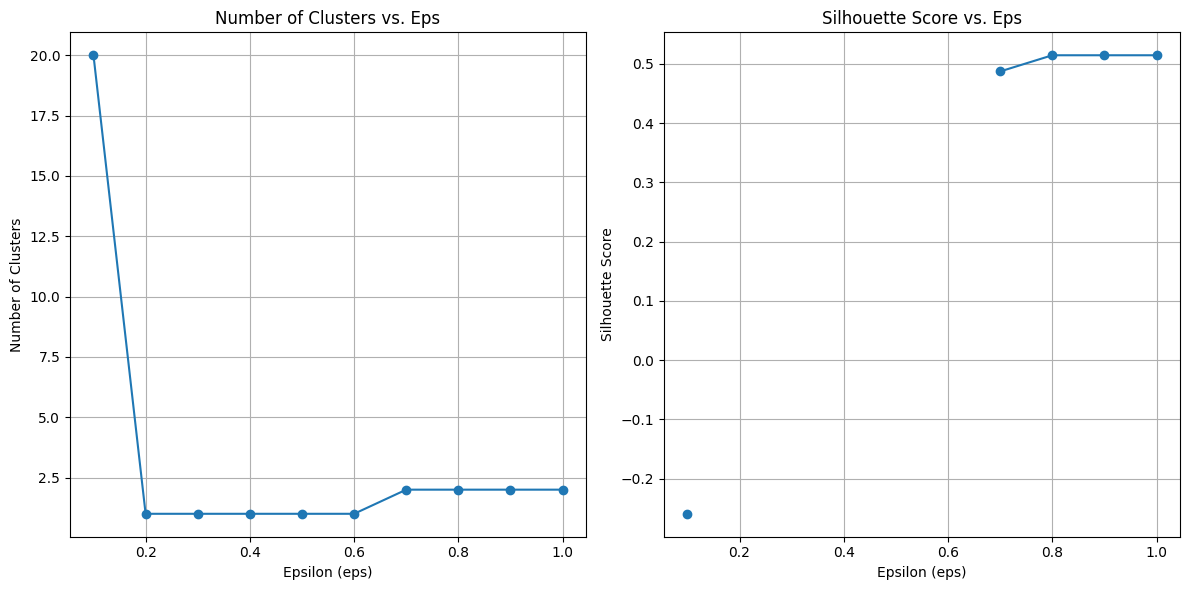

In [ ]:
# Define a range of eps values to test
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
silhouette_scores = []
n_clusters_list = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(transformed_data)

    # Count the number of clusters (excluding noise points labeled as -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_clusters_list.append(n_clusters)

    # Calculate silhouette score if there are at least 2 clusters
    if n_clusters > 1:
        score = silhouette_score(transformed_data, labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(float('nan'))

plt.figure(figsize=(12, 6))

# Plot the number of clusters
plt.subplot(1, 2, 1)
plt.plot(eps_values, n_clusters_list, marker='o')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Eps')
plt.grid()

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(eps_values, silhouette_scores, marker='o')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Eps')
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# Load preprocessed dataset
data = pd.read_csv('/content/Export3.csv')

# Select numeric columns only
numeric_columns = data.select_dtypes(include=[np.number]).columns
numeric_data = data[numeric_columns]

# Standardize all numeric features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Perform PCA
pca = IncrementalPCA(n_components=2)
transformed_data = pca.fit_transform(scaled_data)

# Clustering using DBSCAN
dbscan = DBSCAN(eps=0.04, min_samples=5)  # You can tune eps and min_samples based on your data
clusters = dbscan.fit_predict(transformed_data)

# Convert PCA-transformed data to DataFrame
plot_df = pd.DataFrame(transformed_data, columns=['X', 'Y'])
plot_df['Cluster'] = clusters

# Include the original ID column for hover data
plot_df['id'] = data['id']  # Ensure 'ID' exists in your dataset

# Plotting with Plotly
fig = px.scatter(
    plot_df,
    x='X',
    y='Y',
    color='Cluster',
    hover_data={'id': True},  # Use 'ID' for hover data
    title="PCA and Clustering with Feature Scaling and Weighting (DBSCAN)",
    labels={'X': 'Principal Component 1', 'Y': 'Principal Component 2'}
)
fig.update_layout(
    xaxis=dict(scaleanchor="y", scaleratio=1),
    yaxis=dict(scaleanchor="x", scaleratio=1),
    legend=dict(title="Cluster"),
)
fig.show()


#Visualization with K Means
After performing PCA, we also tried using the K means algorithm to visualize our dataset. To determine the ideal K, graph various K values and graph along with the sum or squared error from the center of each cluster.

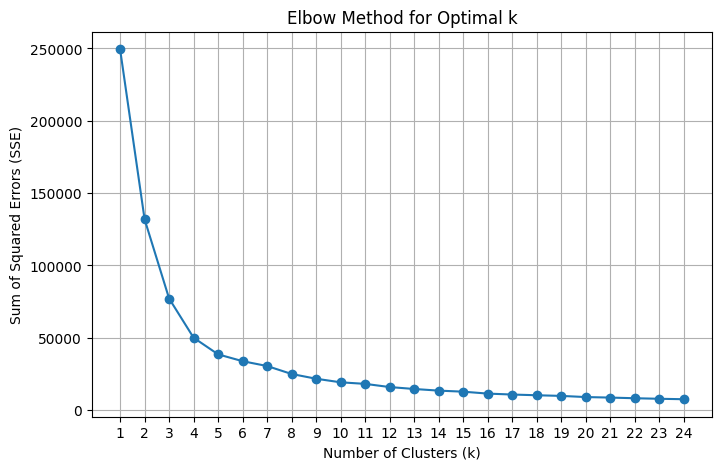

In [ ]:
# Define range of k values
k_values = range(1, 25)

sse = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(transformed_data)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_values)
plt.grid()
plt.show()

In [ ]:
# Load preprocessed dataset
data = pd.read_csv('/content/Export3.csv')

# Select numeric columns only
numeric_columns = data.select_dtypes(include=[np.number]).columns
numeric_data = data[numeric_columns]

# Standardize all numeric features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Perform PCA
pca = IncrementalPCA(n_components=2)
transformed_data = pca.fit_transform(scaled_data)

# Clustering using K-Means
kmeans = KMeans(n_clusters=32, random_state=42)
clusters = kmeans.fit_predict(transformed_data)

# Convert PCA-transformed data to DataFrame
plot_df = pd.DataFrame(transformed_data, columns=['X', 'Y'])
plot_df['Cluster'] = clusters

# Include the original ID column for hover data
plot_df['id'] = data['id']  # Ensure 'ID' exists in your dataset

# Plotting with Plotly
fig = px.scatter(
    plot_df,
    x='X',
    y='Y',
    color='Cluster',
    hover_data={'id': True},  # Use 'ID' for hover data
    title="PCA and Clustering with Feature Scaling and Weighting",
    labels={'X': 'Principal Component 1', 'Y': 'Principal Component 2'}
)
fig.update_layout(
    xaxis=dict(scaleanchor="y", scaleratio=1),
    yaxis=dict(scaleanchor="x", scaleratio=1),
    legend=dict(title="Cluster"),
)
fig.show()


#Important Test Methods
After finding a specific id of a piece of clothing as well as it's corresponding cluster, you can pull images of other pieces in the same cluster to evaluate the model's performance. Then, you can try creating an outfit based on the model.

In [ ]:
# Specify the ID for which you want to find the cluster
specific_id = 35916  # Replace with the actual ID

# Find the cluster for the specific ID
cluster_of_id = plot_df.loc[plot_df['id'] == specific_id, 'Cluster'].values

if len(cluster_of_id) > 0:
    print(f"The cluster for ID {specific_id} is: {cluster_of_id[0]}")
else:
    print(f"ID {specific_id} not found in the dataset.")


ID 35916 not found in the dataset.


random IDs from cluster 10: [18616, 4239, 48093, 30933, 14998, 6168, 14071, 32654, 11668, 12907, 18969, 7458, 21408, 40436, 5204, 31635, 12226, 28992, 39161, 12116]


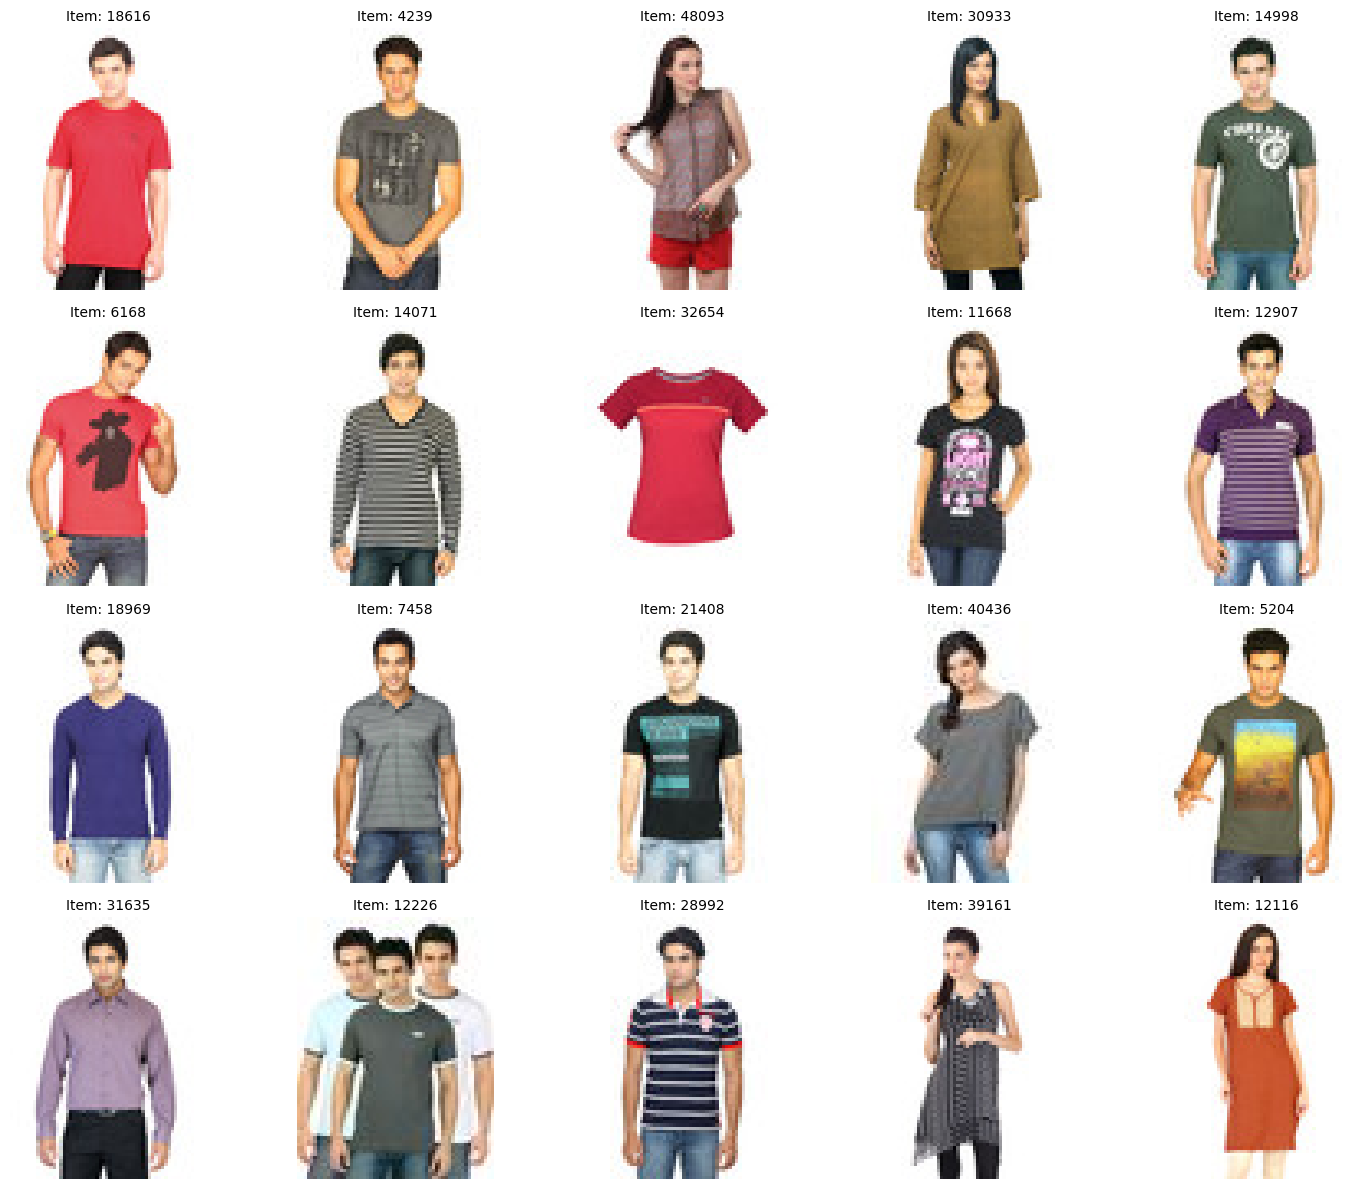

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os


import random

# Replace `0` with the desired cluster number
selected_cluster = 10 # Adjust this based on your desired cluster
cluster_ids = plot_df[plot_df['Cluster'] == selected_cluster]['id']

# Randomly select 20 IDs from the cluster
random_ids = cluster_ids.sample(n=20,replace =True).tolist()

# Print the result
print(f"random IDs from cluster {selected_cluster}: {random_ids}")


# Set the dataset path and selected IDs
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
ids = random_ids

# Create a figure for the grid
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12))  # Adjust rows and cols as needed for your grid
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Load and display each image
for ax, id in zip(axes, ids):
    random_id = str(id)
    random_image_path = os.path.join(path, "images", f"{random_id}.jpg")

    try:
        image = mpimg.imread(random_image_path)
        ax.imshow(image)
        ax.axis('off')  # Remove axes
        ax.set_title(f"Item: {id}", fontsize=10)
    except FileNotFoundError:
        ax.axis('off')
        ax.set_title("Image not found", fontsize=10)

# Hide unused subplots if there are fewer images than grid cells
for ax in axes[len(ids):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


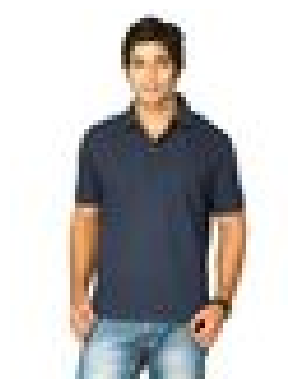

Selected Item: id                      7787
gender                     1
masterCategory       Apparel
subCategory          Topwear
articleType          Tshirts
red               112.230674
green             111.836296
blue              116.028938
season                     1
usage                 Casual
Name: 40890, dtype: object


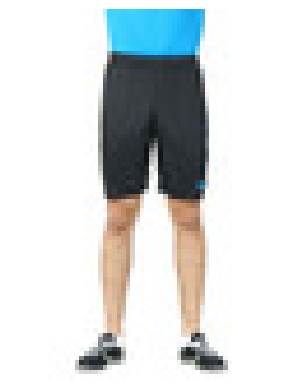

Selected Item: id                      9674
gender                     1
masterCategory       Apparel
subCategory       Bottomwear
articleType           Shorts
red               142.060106
green             140.931644
blue              131.169711
season                     1
usage                 Casual
Name: 21078, dtype: object


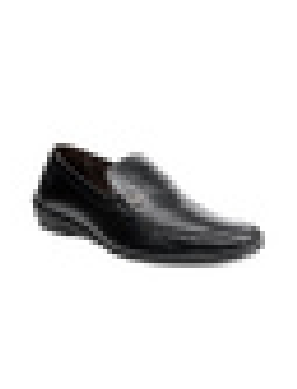

Selected Item: id                       57524
gender                       1
masterCategory        Footwear
subCategory              Shoes
articleType       Casual Shoes
red                  116.15274
green               115.473495
blue                115.880503
season                       1
usage                   Casual
Name: 20810, dtype: object


In [ ]:
closet = pd.read_csv("/content/Export2.csv")
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
def generate_outfit(closet, red_range, blue_range, green_range):
    # Filter for topwear
    usage = ""
    top = closet[
        (closet['subCategory'] == "Topwear") &
        (closet['red'].between(*red_range)) &
        (closet['blue'].between(*blue_range)) &
        (closet['green'].between(*green_range))
    ]
    if top.empty:
        print("No matching topwear found.")
    else:
        top = top.sample(1)
        usage = top.iloc[0]['usage']

    # Filter for bottomwear
    bottom = closet[
        (closet['subCategory'] == "Bottomwear") &
        (closet['red'].between(*red_range)) &
        (closet['blue'].between(*blue_range)) &
        (closet['green'].between(*green_range)) &
        (closet['usage'] == usage)
    ]
    if bottom.empty:
        print("No matching bottomwear found.")
    else:
        bottom = bottom.sample(1)

    # Filter for shoes
    shoe = closet[
        (closet['subCategory'] == "Shoes") &
        (closet['red'].between(*red_range)) &
        (closet['blue'].between(*blue_range)) &
        (closet['green'].between(*green_range)) &
        (closet['usage'] == usage)
    ]
    if shoe.empty:
        print("No matching shoes found.")
    else:
        shoe = shoe.sample(1)

    return [top, bottom, shoe]

red_range = (100, 150)
blue_range = (100, 150)
green_range = (100, 150)
# Generate the outfit
outfit = generate_outfit(closet, red_range, blue_range, green_range)

# Plot and display each selected item
for item in outfit:
    if not item.empty:
        target_index = item.iloc[0]
        random_id = target_index["id"]
        random_image_path = f"{path}/images/{random_id}.jpg"

        # Load and display the image
        try:
            image = mpimg.imread(random_image_path)
            plt.imshow(image)
            plt.axis('off')
            plt.show()
            print(f"Selected Item: {target_index}")
        except FileNotFoundError:
            print(f"Image not found: {random_image_path}")


#Metric Tests for Accuracy
This method loops through the various clusters produced and references each piece's ID to determine how much of the cluster is correctly grouped with one another. For example, it a pair of pants is found in a cluster of dark colored Tshirts, we would count that as an incorrect classification.

In [ ]:
import pandas as pd

# Number of clusters
numOfClusters = plot_df['Cluster'].nunique()

# Load data
data = pd.read_csv(path + "/styles.csv", on_bad_lines='skip')

# Initialize cluster frequency dictionary
clusterFreqs = {}

for i in range(numOfClusters):
    # Get all IDs for the current cluster
    cluster_ids = plot_df[plot_df['Cluster'] == i]['id']
    clusterFreq = {}

    for id in cluster_ids:
        # Find the masterCategory for the current ID
        masterCategory = data.loc[data['id'] == id, 'masterCategory'].values

        if len(masterCategory) > 0:  # Ensure masterCategory exists
            category = masterCategory[0]  # Extract the first value

            # Update cluster frequency
            clusterFreq[category] = clusterFreq.get(category, 0) + 1

    # Calculate frequency ratio
    if clusterFreq:  # Ensure clusterFreq is not empty
        maxFreq = max(clusterFreq.values())
        totalFreq = sum(clusterFreq.values())
        clusterFreqs[i] = maxFreq / totalFreq
    else:
        clusterFreqs[i] = 0  # Handle empty clusters

# Print cluster frequency dictionary
print(clusterFreqs)


{0: 0.7919621749408984, 1: 0.7178642056690837, 2: 1.0, 3: 1.0, 4: 0.755741127348643, 5: 0.9822222222222222, 6: 0.756294058408862, 7: 1.0, 8: 0.9651639344262295, 9: 0.9583333333333334, 10: 1.0, 11: 0.672231985940246, 12: 0.7777777777777778, 13: 0.7884615384615384, 14: 0.5242369838420108, 15: 0.9793530626290433, 16: 1.0, 17: 1.0, 18: 1.0, 19: 0.9917043740573153, 20: 0.4676564156945917, 21: 0.9962779156327544, 22: 0.8110867979576951, 23: 0.9974489795918368, 24: 1.0, 25: 0.9072512647554806, 26: 0.9694767441860465, 27: 0.5900383141762452, 28: 0.5299442896935933, 29: 0.8335714285714285, 30: 0.5767148014440433, 31: 1.0}


Calculate average Cluster Accuracy

In [ ]:
totalAccuracy = 0
for accuracy in clusterFreqs.values():
  totalAccuracy += accuracy
print(totalAccuracy / numOfClusters)

0.8544004290862787


#Testing Recommendation Clustering Based Recommendations

#Miscallaneous Code I didn't want to delete

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
import spacy
import plotly.express as px
from scipy import stats

# Load SpaCy model
nlp = spacy.load("en_core_web_md")

def preprocess_text_column(data, column, nlp):
    """
    Convert text into numeric embeddings using SpaCy.
    """
    text_column = data[column].astype(str)  # Ensure all values are strings
    docs = list(nlp.pipe(text_column, disable=["parser", "tagger", "ner"]))  # Batch process
    vectors = np.array([doc.vector for doc in docs])  # Extract vectors for each doc

    return vectors
# # Filter and clean your dataset
filtered_data = data[data['masterCategory'].isin(['Apparel', 'Footwear'])].copy()  # Keep only rows with 'Apparel'
filtered_data = filtered_data.drop(columns=["id", "usage", "year", "productDisplayName"])  # Drop unnecessary columns

# Handle missing values
filtered_data["subCategory"] = filtered_data["subCategory"].fillna("")

# Text columns to process
text_columns = ["subCategory", "articleType", "baseColour", "season"]

# Check for missing columns
required_columns = text_columns
missing_columns = [col for col in required_columns if col not in filtered_data.columns]
if missing_columns:
    raise ValueError(f"Missing columns: {missing_columns}")

# Process text columns
embedded_columns = {}
for col in text_columns:
    embedded_columns[col] = preprocess_text_column(filtered_data, col, nlp)

# Replace original columns with embeddings
for col, embeddings in embedded_columns.items():
    embedding_df = pd.DataFrame(embeddings, columns=[f"{col}_dim{i}" for i in range(embeddings.shape[1])])
    filtered_data = pd.concat([filtered_data.reset_index(drop=True), embedding_df.reset_index(drop=True)], axis=1)
    filtered_data = filtered_data.drop(columns=[col])
    # filtered_data[col] = list(embeddings)

filtered_data = pd.get_dummies(filtered_data, columns=['gender'], drop_first=True)
# filtered_data['year'] = filtered_data['year'].fillna(filtered_data['year'].mean())
filtered_data = filtered_data.drop(columns = ['masterCategory'])

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(filtered_data)

# Perform PCA
transformer = IncrementalPCA(n_components=2)
transformed_data = transformer.fit_transform(scaled_data)

# Identify outliers using Z-score
z_scores = np.abs(stats.zscore(transformed_data))
outlier_indices = np.where((z_scores > 2).any(axis=1))[0]

# Separate non-outliers and outliers
data_no_outliers = transformed_data[(z_scores < 2).all(axis=1)]
non_outlier_indices = np.where((z_scores < 2).all(axis=1))[0]

# Convert data to DataFrame for Plotly visualization
plot_df = pd.DataFrame(transformed_data, columns=['X', 'Y'])
plot_df['Index'] = range(len(transformed_data))
plot_df['Type'] = ['Outlier' if i in outlier_indices else 'Non-Outlier' for i in range(len(transformed_data))]

# Plotting with Plotly for interactivity
fig = px.scatter(plot_df, x='Y', y='X', color='Type', hover_data={'Index': True},
                 title="Interactive 2D Plot of Transformed Data with Outliers Marked")
fig.update_layout(
    xaxis=dict(scaleanchor="y", scaleratio=1),
    yaxis=dict(scaleanchor="x", scaleratio=1)
)

# Display the interactive plot
fig.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
import spacy
import plotly.express as px
from scipy import stats

# Load SpaCy model
nlp = spacy.load("en_core_web_md")

def preprocess_text_column(data, column, nlp):
    """
    Convert text into numeric embeddings using SpaCy.
    """
    text_column = data[column].astype(str)  # Ensure all values are strings
    docs = list(nlp.pipe(text_column, disable=["parser", "tagger", "ner"]))  # Batch process
    vectors = np.array([doc.vector for doc in docs])  # Extract vectors for each doc

    return vectors
# # Filter and clean your dataset
filtered_data = data[data['masterCategory'].isin(['Apparel', 'Footwear'])].copy()  # Keep only rows with 'Apparel'
filtered_data = filtered_data.drop(columns=["id", "usage", "year", "productDisplayName"])  # Drop unnecessary columns

# Handle missing values
filtered_data["subCategory"] = filtered_data["subCategory"].fillna("")

# Text columns to process
text_columns = ["subCategory", "articleType", "baseColour", "season"]

# Check for missing columns
required_columns = text_columns
missing_columns = [col for col in required_columns if col not in filtered_data.columns]
if missing_columns:
    raise ValueError(f"Missing columns: {missing_columns}")

# Process text columns
embedded_columns = {}
for col in text_columns:
    embedded_columns[col] = preprocess_text_column(filtered_data, col, nlp)

# Replace original columns with embeddings
for col, embeddings in embedded_columns.items():
    embedding_df = pd.DataFrame(embeddings, columns=[f"{col}_dim{i}" for i in range(embeddings.shape[1])])
    filtered_data = pd.concat([filtered_data.reset_index(drop=True), embedding_df.reset_index(drop=True)], axis=1)
    filtered_data = filtered_data.drop(columns=[col])
    # filtered_data[col] = list(embeddings)

filtered_data = pd.get_dummies(filtered_data, columns=['gender'], drop_first=True)
# filtered_data['year'] = filtered_data['year'].fillna(filtered_data['year'].mean())
filtered_data = filtered_data.drop(columns = ['masterCategory'])

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(filtered_data)

# Perform PCA
transformer = IncrementalPCA(n_components=2)
transformed_data = transformer.fit_transform(scaled_data)

# Identify outliers using Z-score
z_scores = np.abs(stats.zscore(transformed_data))
outlier_indices = np.where((z_scores > 2).any(axis=1))[0]

# Separate non-outliers and outliers
data_no_outliers = transformed_data[(z_scores < 2).all(axis=1)]
non_outlier_indices = np.where((z_scores < 2).all(axis=1))[0]

# Convert data to DataFrame for Plotly visualization
plot_df = pd.DataFrame(transformed_data, columns=['X', 'Y'])
plot_df['Index'] = range(len(transformed_data))
plot_df['Type'] = ['Outlier' if i in outlier_indices else 'Non-Outlier' for i in range(len(transformed_data))]

# Plotting with Plotly for interactivity
fig = px.scatter(plot_df, x='Y', y='X', color='Type', hover_data={'Index': True},
                 title="Interactive 2D Plot of Transformed Data with Outliers Marked")
fig.update_layout(
    xaxis=dict(scaleanchor="y", scaleratio=1),
    yaxis=dict(scaleanchor="x", scaleratio=1)
)

# Display the interactive plot
fig.show()


In [ ]:
ids = [9785,4097,3680]
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
for id in ids:
  randomImage = path + "/images/" + str(id) + ".jpg"
  image = mpimg.imread(randomImage)
  plt.imshow(image)
  plt.axis('off')
  plt.show()


#Dimension Reduction & PreProcessing

Note that you will need to first change strings into discrete floats/numbers before you can begin your transformation of them. Also, you must run inceremental PCA due to memory restrictions. Then, we can verify whether it has worked by comparing data points visually.

In [ ]:
import pandas as pd

# Assuming your data is in a pandas DataFrame called 'data'

# Group data by subCategory and get unique masterCategories for each
subcategory_categories = data.groupby('subCategory')['masterCategory'].unique()

# Print the results
for subcategory, categories in subcategory_categories.items():
    print(f"Subcategory: {subcategory}")
    print(f"Categories: {categories}")
    print("-" * 20)  # Separator for better readability

In [ ]:
# Install SpaCy
!pip install spacy

# Download the en_core_web_md model
!python -m spacy download en_core_web_md


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
import spacy
import plotly.express as px
from scipy import stats

# Load SpaCy model
nlp = spacy.load("en_core_web_md")

def preprocess_text_column(data, column, nlp):
    """
    Convert text into numeric embeddings using SpaCy.
    """
    text_column = data[column].astype(str)  # Ensure all values are strings
    docs = list(nlp.pipe(text_column, disable=["parser", "tagger", "ner"]))  # Batch process
    vectors = np.array([doc.vector for doc in docs])  # Extract vectors for each doc

    return vectors
# # Filter and clean your dataset
filtered_data = data[data['masterCategory'].isin(['Apparel', 'Footwear'])].copy()  # Keep only rows with 'Apparel'
filtered_data = filtered_data.drop(columns=["id", "usage", "year", "productDisplayName"])  # Drop unnecessary columns

# Handle missing values
filtered_data["subCategory"] = filtered_data["subCategory"].fillna("")

# Text columns to process
text_columns = ["subCategory", "articleType", "baseColour", "season"]

# Check for missing columns
required_columns = text_columns
missing_columns = [col for col in required_columns if col not in filtered_data.columns]
if missing_columns:
    raise ValueError(f"Missing columns: {missing_columns}")

# Process text columns
embedded_columns = {}
for col in text_columns:
    embedded_columns[col] = preprocess_text_column(filtered_data, col, nlp)

# Replace original columns with embeddings
for col, embeddings in embedded_columns.items():
    embedding_df = pd.DataFrame(embeddings, columns=[f"{col}_dim{i}" for i in range(embeddings.shape[1])])
    filtered_data = pd.concat([filtered_data.reset_index(drop=True), embedding_df.reset_index(drop=True)], axis=1)
    filtered_data = filtered_data.drop(columns=[col])
    # filtered_data[col] = list(embeddings)

filtered_data = pd.get_dummies(filtered_data, columns=['gender'], drop_first=True)
# filtered_data['year'] = filtered_data['year'].fillna(filtered_data['year'].mean())
filtered_data = filtered_data.drop(columns = ['masterCategory'])

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(filtered_data)

# Perform PCA
transformer = IncrementalPCA(n_components=2)
transformed_data = transformer.fit_transform(scaled_data)

# Identify outliers using Z-score
z_scores = np.abs(stats.zscore(transformed_data))
outlier_indices = np.where((z_scores > 2).any(axis=1))[0]

# Separate non-outliers and outliers
data_no_outliers = transformed_data[(z_scores < 2).all(axis=1)]
non_outlier_indices = np.where((z_scores < 2).all(axis=1))[0]

# Convert data to DataFrame for Plotly visualization
plot_df = pd.DataFrame(transformed_data, columns=['X', 'Y'])
plot_df['Index'] = range(len(transformed_data))
plot_df['Type'] = ['Outlier' if i in outlier_indices else 'Non-Outlier' for i in range(len(transformed_data))]

# Plotting with Plotly for interactivity
fig = px.scatter(plot_df, x='Y', y='X', color='Type', hover_data={'Index': True},
                 title="Interactive 2D Plot of Transformed Data with Outliers Marked")
fig.update_layout(
    xaxis=dict(scaleanchor="y", scaleratio=1),
    yaxis=dict(scaleanchor="x", scaleratio=1)
)

# Display the interactive plot
fig.show()


In [ ]:
# from sklearn.decomposition import IncrementalPCA
# from scipy import stats
# import spacy
# # from gensim.models import Word2Vec


# # subcategory_list = data['subCategory'].unique().tolist()
# # w2v_model = Word2Vec([[subcategory] for subcategory in subcategory_list], vector_size=5, min_count=1, window=2)

# # def get_embedding(subcategory):
# #     if subcategory in w2v_model.wv:
# #         return w2v_model.wv[subcategory]
# #     else:
# #         return np.zeros(w2v_model.vector_size)

# # data['subCategory_embedding'] = data['subCategory'].apply(get_embedding)
# # embedding_df = pd.DataFrame(data['subCategory_embedding'].tolist(), columns=[f'embed_{i}' for i in range(w2v_model.vector_size)])
# # data = pd.concat([data, embedding_df], axis=1)

# nlp = spacy.load('en_core_web_md')

# def preProcess(entry):
#   if pd.isna(entry):
#       return 0
#   elif isinstance(entry, str):
#       return float('0.' + ''.join(str(ord(char)) for char in entry)) * 255
#   return entry

# processedData = data.drop(columns=["id","usage", "productDisplayName"]).map(preProcess)
# transformer = IncrementalPCA(n_components=2)
# transformer.fit(processedData)
# testData = transformer.transform(processedData)

# # This is chatGPT code and below
# z_scores = np.abs(stats.zscore(testData))
# outlier_indices = np.where((z_scores > 2).any(axis=1))[0]  # Indices of rows with Z-score > 2 in any column

# # Separate non-outliers and outliers
# data_no_outliers = testData[(z_scores < 2).all(axis=1)]
# non_outlier_indices = np.where((z_scores < 2).all(axis=1))[0]

# # Convert data to DataFrame for Plotly
# plot_df = pd.DataFrame(testData, columns=['X', 'Y'])
# plot_df['Index'] = range(len(testData))
# plot_df['Type'] = ['Outlier' if i in outlier_indices else 'Non-Outlier' for i in range(len(testData))]

# # Plotting with Plotly for interactivity
# fig = px.scatter(plot_df, x='Y', y='X', color='Type', hover_data={'Index': True},
#                  title="Interactive 2D Plot of Test Data with Outliers Marked")
# fig.update_layout(
#     xaxis=dict(scaleanchor="y", scaleratio=1),
#     yaxis=dict(scaleanchor="x", scaleratio=1)
# )
# # Display the interactive plot
# fig.show()

In [ ]:
targetIndices = [18800,29177,545]
for targetIndex in targetIndices:
  randomId = data.iloc[targetIndex]["id"]
  randomImage = path + "/images/" + str(randomId) + ".jpg"
  image = mpimg.imread(randomImage)
  print(targetIndex)
  print(data.iloc[targetIndex])
  plt.imshow(image)
  plt.axis('off')
  plt.show()


In [ ]:
# Example: Extracting labels for each category
print(filtered_data)
y_top = filtered_data['Topwear'].values
y_bottom = filtered_data['Bottomwear'].values
y_accessory = filtered_data['Shoes'].values


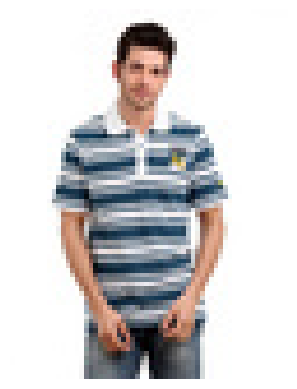

Selected Item: id                     58724
gender                     1
masterCategory       Apparel
subCategory          Topwear
articleType          Tshirts
red               146.649489
green             144.884496
blue               149.86406
season                     0
usage                 Casual
Name: 27516, dtype: object
Image not found: /root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-small/versions/1/images/12347.jpg


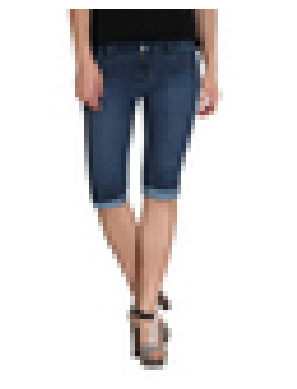

Selected Item: id                     57217
gender                     0
masterCategory       Apparel
subCategory       Bottomwear
articleType           Capris
red               111.534287
green             109.342278
blue              117.286822
season                     1
usage                 Casual
Name: 32491, dtype: object
Image not found: /root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-small/versions/1/images/12347.jpg


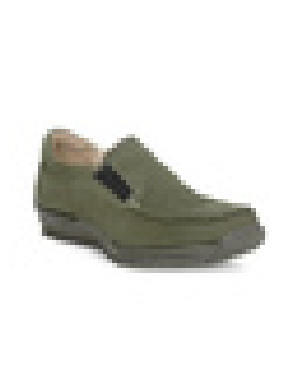

Selected Item: id                       59177
gender                       1
masterCategory        Footwear
subCategory              Shoes
articleType       Casual Shoes
red                 125.391006
green               138.436738
blue                138.939787
season                       0
usage                   Casual
Name: 8436, dtype: object
Image not found: /root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-small/versions/1/images/12347.jpg


In [ ]:
closet = pd.read_csv("/content/Export2.csv")
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
def generate_outfit(closet, red_range, blue_range, green_range):
    # Filter for topwear
    usage = ""
    top = closet[
        (closet['subCategory'] == "Topwear") &
        (closet['red'].between(*red_range)) &
        (closet['blue'].between(*blue_range)) &
        (closet['green'].between(*green_range))
    ]
    if top.empty:
        print("No matching topwear found.")
    else:
        top = top.sample(1)
        usage = top.iloc[0]['usage']

    # Filter for bottomwear
    bottom = closet[
        (closet['subCategory'] == "Bottomwear") &
        (closet['red'].between(*red_range)) &
        (closet['blue'].between(*blue_range)) &
        (closet['green'].between(*green_range)) &
        (closet['usage'] == usage)
    ]
    if bottom.empty:
        print("No matching bottomwear found.")
    else:
        bottom = bottom.sample(1)

    # Filter for shoes
    shoe = closet[
        (closet['subCategory'] == "Shoes") &
        (closet['red'].between(*red_range)) &
        (closet['blue'].between(*blue_range)) &
        (closet['green'].between(*green_range)) &
        (closet['usage'] == usage)
    ]
    if shoe.empty:
        print("No matching shoes found.")
    else:
        shoe = shoe.sample(1)

    return [top, bottom, shoe]

red_range = (100, 150)
blue_range = (100, 150)
green_range = (100, 150)
# Generate the outfit
outfit = generate_outfit(closet, red_range, blue_range, green_range)

# Plot and display each selected item
for item in outfit:
    if not item.empty:
        target_index = item.iloc[0]
        random_id = target_index["id"]
        random_image_path = f"{path}/images/{random_id}.jpg"

        # Load and display the image
        try:
            image = mpimg.imread(random_image_path)
            plt.imshow(image)
            plt.axis('off')
            plt.show()
            print(f"Selected Item: {target_index}")
        except FileNotFoundError:
            print(f"Image not found: {random_image_path}")


        random_image_path = f"{path}/images/12347.jpg"

        # Load and display the image
        try:
            image = mpimg.imread(random_image_path)
            plt.imshow(image)
            plt.axis('off')
            plt.show()
            print(f"Selected Item: {target_index}")
        except FileNotFoundError:
            print(f"Image not found: {random_image_path}")



In [ ]:
import pandas as pd
import spacy
import cv2
import numpy as np
from google.colab import files


# Path to dataset and images
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")

# Load the dataset
data = pd.read_csv(path + "/styles.csv", on_bad_lines='skip')

# Preallocate arrays for results
results = {
    'id': [],
    'gender': [],
    'masterCategory': [],
    'subCategory': [],
    'articleType': [],
    'red': [],
    'green': [],
    'blue': [],
    'season': [],
    'usage': []
}


# Vectorized Gender and Season Processing
gender_map = {'Women': 0, 'Men': 1}
data['gender_numeric'] = data['gender'].map(gender_map).fillna(2).astype(int)
data['season_numeric'] = data['season'].apply(
    lambda x: 0 if x in ['Spring', 'Summer'] else (1 if x in ['Fall', 'Winter'] else 2)
)

# Process Images and Categories
for _, row in data.iterrows():
    id = row['id']
    masterCategory = row['masterCategory']
    usage = row['usage']
    subcategory_sim = row['subCategory']
    articleType_sim = row['articleType']

    try:
        # Load and process the image
        image_path = f"{path}/images/{id}.jpg"
        image = cv2.imread(image_path)
        if image is not None:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = np.all(image_rgb != [255, 255, 255], axis=2)
            non_white_pixels = image_rgb[mask]
            if non_white_pixels.size > 0:
                average_color = np.mean(non_white_pixels, axis=0)
                red, green, blue = average_color[::-1]
            else:
                red, green, blue = 0, 0, 0
        else:
            red, green, blue = 0, 0, 0
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        red, green, blue = 0, 0, 0

    # Append results
    results['id'].append(id)
    results['gender'].append(row['gender_numeric'])
    results['season'].append(row['season_numeric'])
    results['subCategory'].append(subcategory_sim)
    results['articleType'].append(articleType_sim)
    results['red'].append(red)
    results['green'].append(green)
    results['blue'].append(blue)
    results['usage'].append(usage)
    results['masterCategory'].append(masterCategory)
    # One-hot encoding

# Convert results to DataFrame
ProcessedData = pd.DataFrame(results)
ProcessedData.to_csv('Export2.csv', index=False)

# Save to CSV
files.download('Export2.csv')



Please upload an image... (or use your item's corresponding closet id if you know it)


Saving 10006.jpg to 10006 (16).jpg
Cluster for ID 10006: 24
Other random IDs from cluster 24: [40075, 31645, 34580, 9553, 4315]
Cluster 24 random IDs: [53780, 19796, 41348, 36861, 2606, 13252]


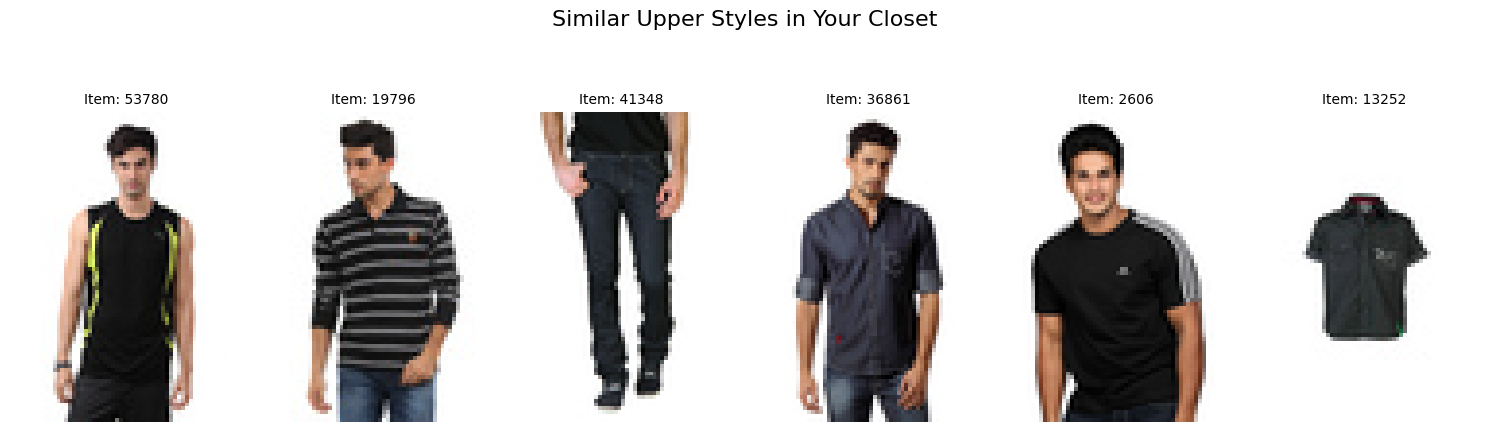

Cluster 17 random IDs: [25903, 50944, 39322, 54342, 50518]


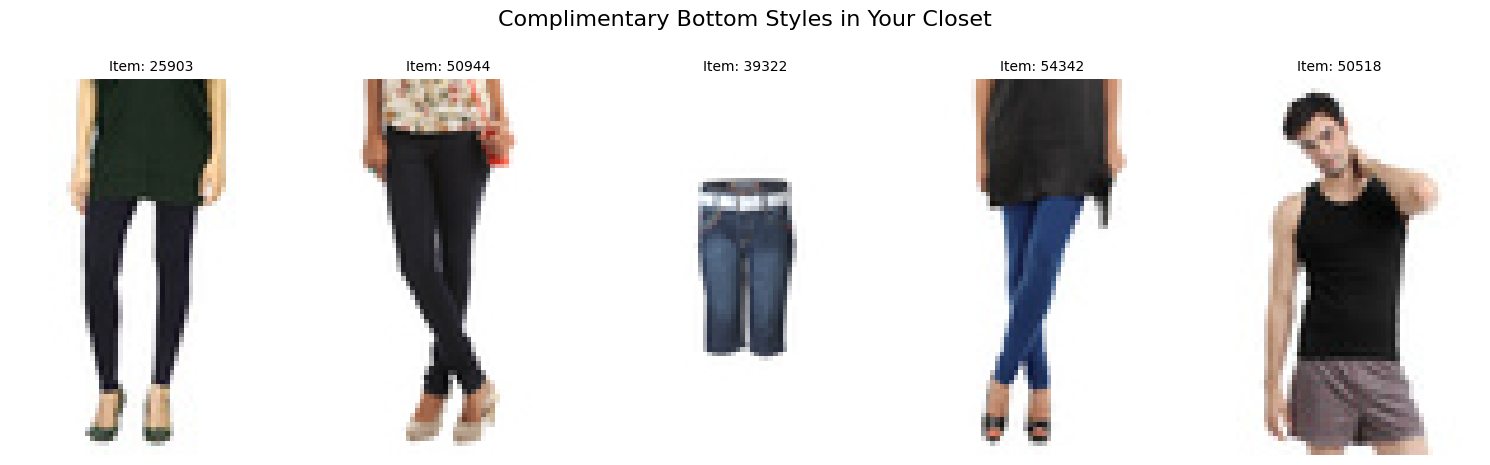

Cluster 13 random IDs: [5944, 3231, 41840, 14337, 25422]


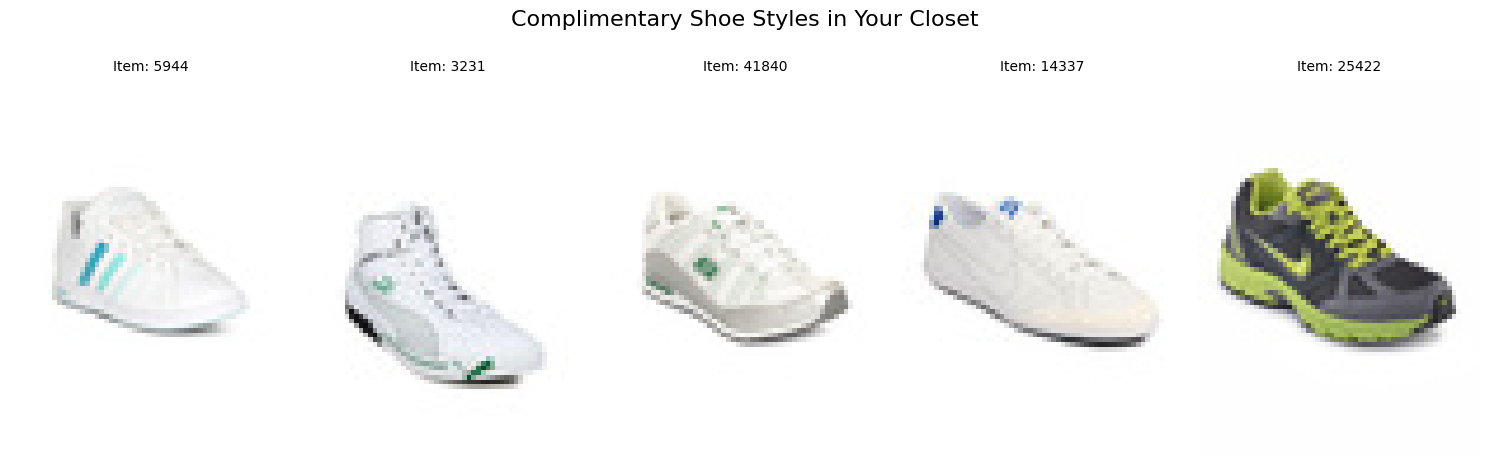

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
pants,shoes = 17,13
# Prompt the user for a specific ID
def get_image_id():
    """
    Prompts the user to upload an image file, extracts the numeric ID from the filename,
    and returns the ID.

    Returns:
        str: The extracted numeric ID from the image filename.
    """
    from google.colab import files

    # Prompt the user to upload an image
    print("\nPlease upload an image... (or use your item's corresponding closet id if you know it)")
    uploaded = files.upload()

    # Process the uploaded file
    for filename in uploaded.keys():
        # Extract only the numeric portion of the filename
        base_name = filename.split()[0]  # Take the first part before any spaces
        numeric_id = base_name.split('.')[0]  # Remove the file extension
        return numeric_id

input_id = get_image_id()

# Function to display images from a specific cluster
def display_cluster_images(cluster_id, path, title="Cluster Images", num_images=5):
    # Get all IDs in the specified cluster
    cluster_ids = plot_df[plot_df['Cluster'] == cluster_id]['id']

    # Randomly select up to `num_images` IDs from the cluster
    random_ids = cluster_ids.sample(n=min(num_images, len(cluster_ids)), replace=False).tolist()

    print(f"Cluster {cluster_id} random IDs: {random_ids}")

    # Create a figure for the grid
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 5))  # Single row for `num_images` images
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    # Load and display each image
    for ax, id in zip(axes, random_ids):
        random_id = str(id)
        random_image_path = os.path.join(path, "images", f"{random_id}.jpg")

        try:
            image = mpimg.imread(random_image_path)
            ax.imshow(image)
            ax.axis('off')  # Remove axes
            ax.set_title(f"Item: {id}", fontsize=10)
        except FileNotFoundError:
            ax.axis('off')
            ax.set_title("Image not found", fontsize=10)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


# Prompt the user for a specifi

# Find the cluster of the specified ID
try:
    selected_cluster = plot_df.loc[plot_df['id'] == int(input_id), 'Cluster'].values[0]
except IndexError:
    print("The entered ID does not exist in the dataset.")
    exit()

# Get all IDs in the same cluster as the input ID
cluster_ids = plot_df[plot_df['Cluster'] == selected_cluster]['id']

# Randomly select 5 IDs from the cluster (excluding the input ID if possible)
cluster_ids = cluster_ids[cluster_ids != int(input_id)]
random_ids = cluster_ids.sample(n=min(5, len(cluster_ids)), replace=False).tolist()

# Print the result
print(f"Cluster for ID {input_id}: {selected_cluster}")
print(f"Other random IDs from cluster {selected_cluster}: {random_ids}")

# Set the dataset path
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")

# Display images from the selected cluster
ids = [int(input_id)] + random_ids  # Include the input ID for visualization
display_cluster_images(selected_cluster, path, title="Similar Upper Styles in Your Closet", num_images=6)

display_cluster_images(pants, path, title="Complimentary Bottom Styles in Your Closet")


display_cluster_images(shoes, path, title="Complimentary Shoe Styles in Your Closet")